In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy.special import expit

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

In [3]:
# true params
β0_true = 0.7
β1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
μ_true = β0_true + β1_true * x
# transformation (inverse logit function = expit)
p_true = expit(μ_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})

In [4]:
data.head()

,x,y
0,-10.000000,3
1,-8.965517,1
2,-7.931034,3
3,-6.896552,1
4,-5.862069,2


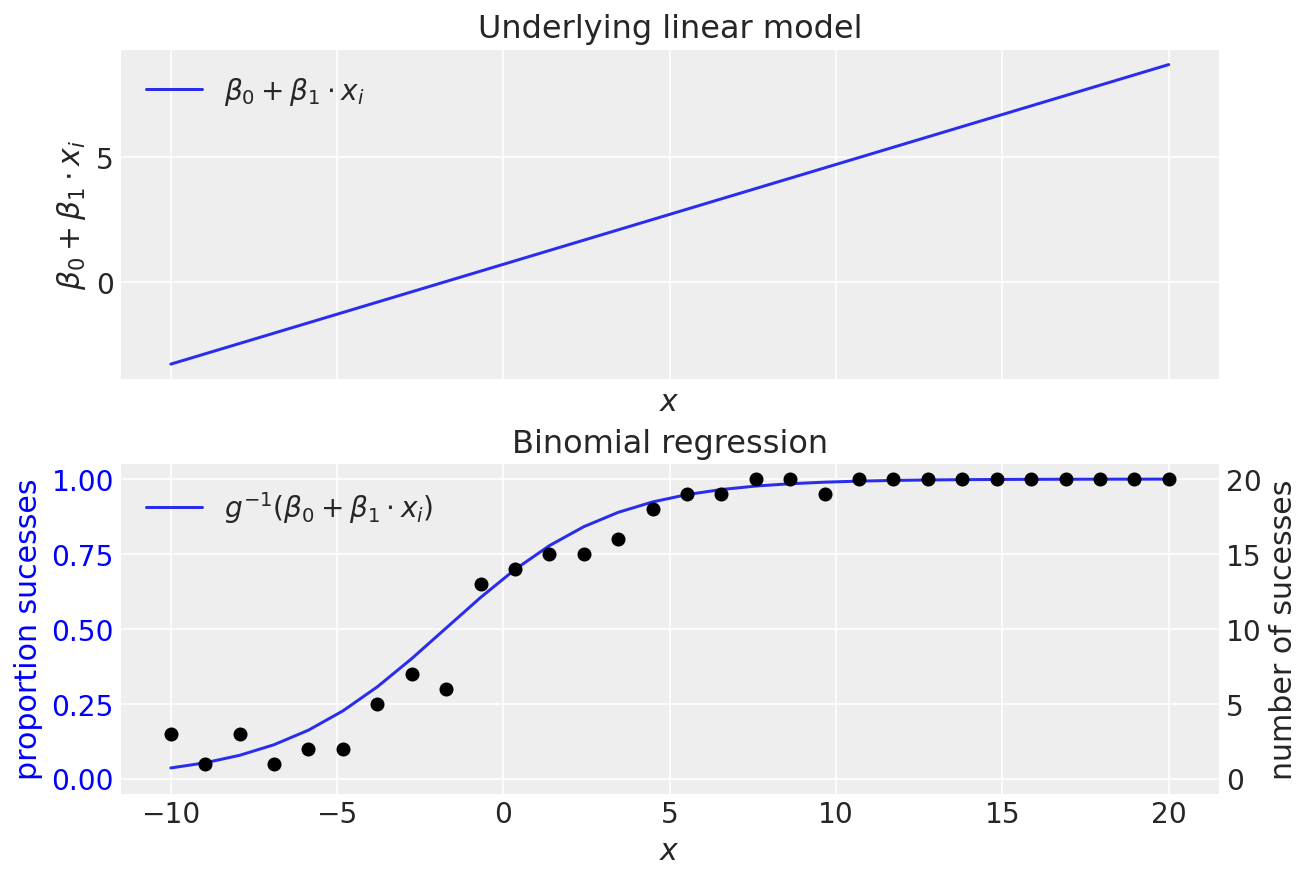

In [5]:
# Plot underlying linear model
fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax[0].plot(x, μ_true, label=r"$β_0 + β_1 \cdot x_i$")
ax[0].set(xlabel="$x$", ylabel=r"$β_0 + β_1 \cdot x_i$", title="Underlying linear model")
ax[0].legend()

# Plot GLM
freq = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
freq.set_ylabel("number of sucesses")
freq.scatter(x, y, color="k")
# plot proportion related stuff on ax[1]
ax[1].plot(x, p_true, label=r"$g^{-1}(β_0 + β_1 \cdot x_i)$")
ax[1].set_ylabel("proportion sucesses", color="b")
ax[1].tick_params(axis="y", labelcolor="b")
ax[1].set(xlabel="$x$", title="Binomial regression")
ax[1].legend()
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[1].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)


In [6]:
coords = {"observation": data.index.values}

with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.Data("x", data["x"], dims="observation")
    # priors
    β0 = pm.Normal("β0", mu=0, sigma=1)
    β1 = pm.Normal("β1", mu=0, sigma=1)
    # linear model
    μ = β0 + β1 * x
    p = pm.Deterministic("p", pm.math.invlogit(μ), dims="observation")
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"], dims="observation")

In [8]:
with binomial_regression_model:
    trace = pm.sample(1000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/kinho.lo/.conda/envs/pymc3_env/lib/python3.10/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/kinho.lo/.conda/envs/pymc3_env/lib/python3.10/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, β0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 33 seconds.


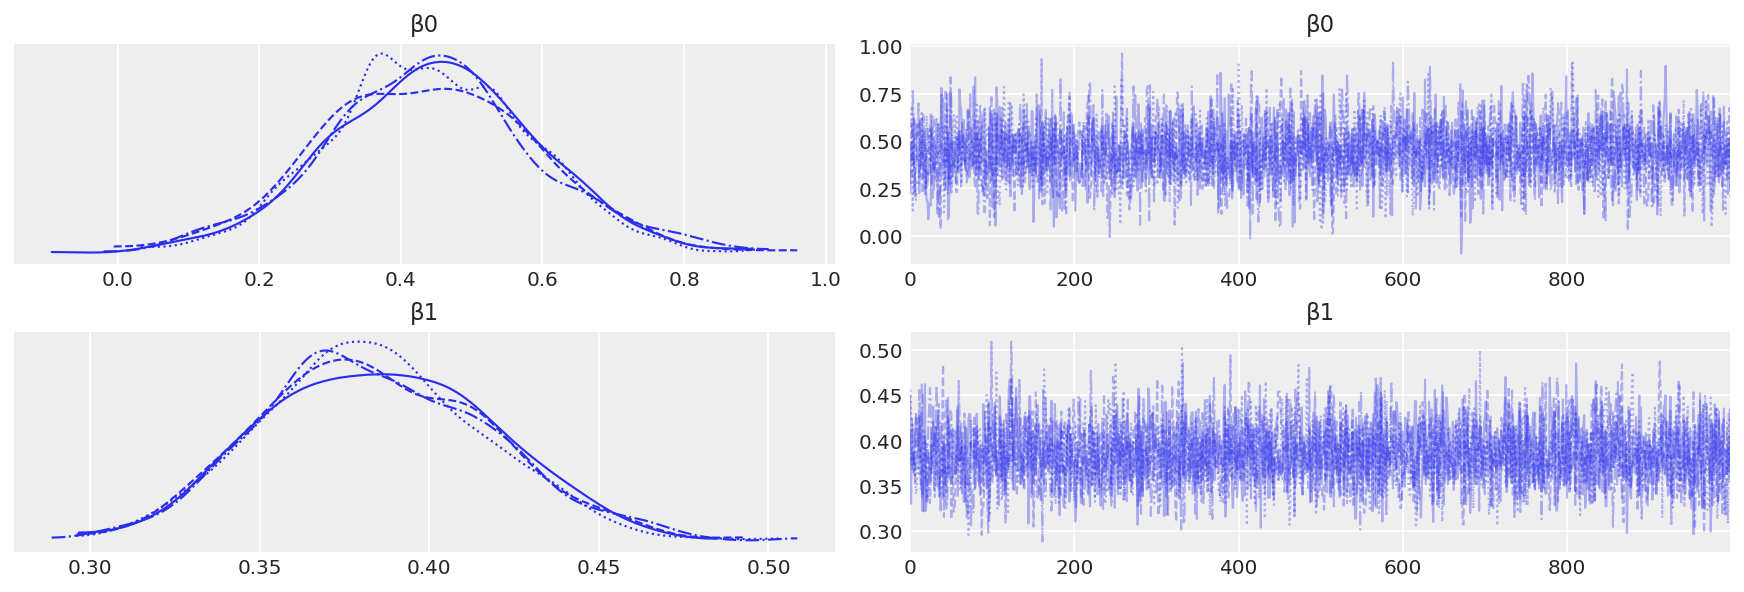

In [9]:
az.plot_trace(trace, var_names=["β0", "β1"]);

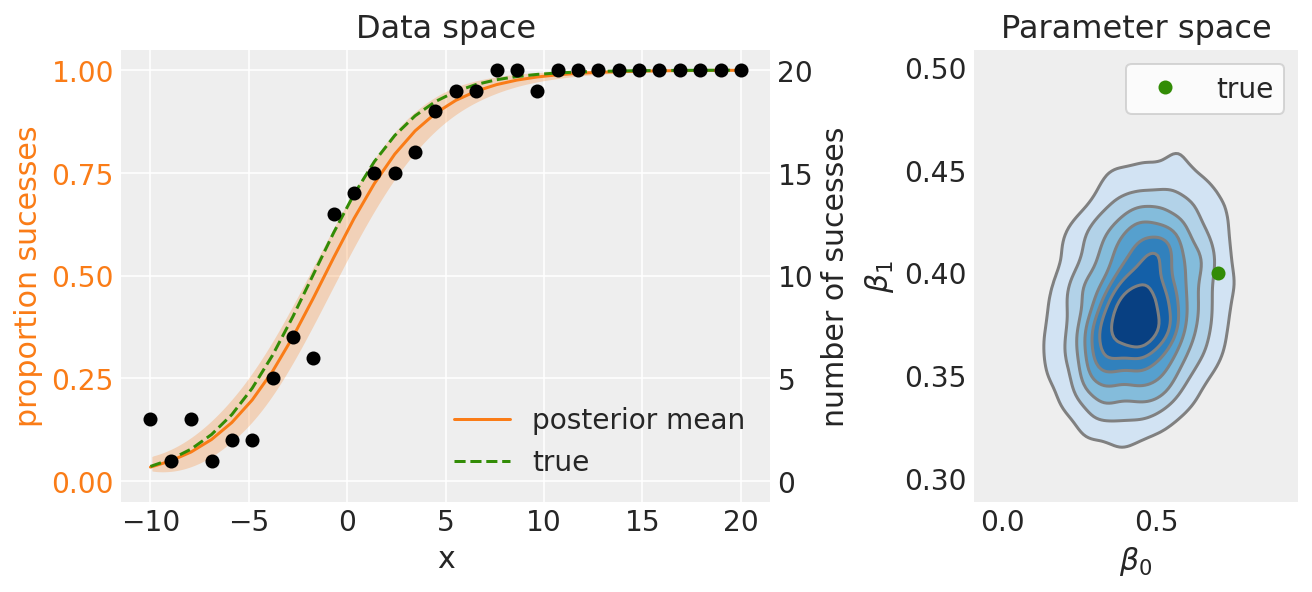

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    trace.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = trace.posterior.stack(sample=("chain", "draw")).p.mean("sample")
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion sucesses", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of sucesses")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    trace.posterior.stack(sample=("chain", "draw")).β0.values,
    trace.posterior.stack(sample=("chain", "draw")).β1.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(β0_true, β1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);